In [1]:
# %% [markdown]
# # 1) Setup
# We'll check TensorFlow version, enable eager execution (default TF2),
# and verify if a GPU is available.

# %%
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print("TensorFlow:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())
print("Physical devices:", tf.config.list_physical_devices())


TensorFlow: 2.18.0
Eager execution: True
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# %% [markdown]
# # 2) Data: Predict next-day order lines (synthetic)
# Features:
# - dow: day of week [0..6]
# - is_promo: 0/1
# - price_index: 0.8..1.2
# - lag_lines: yesterday's lines
# Target:
# - next_lines: next day's order lines

# %%
rng = np.random.default_rng(42)
n = 1500

dow = rng.integers(0, 7, size=n)
is_promo = rng.integers(0, 2, size=n)
price_index = rng.uniform(0.8, 1.2, size=n)

# base demand pattern
base = 80 + 10*np.sin(2*np.pi*(dow)/7)   # weekly seasonality

# create lag, then target
lag_lines = np.clip(rng.normal(100, 25, size=n), 10, 250)

# true generative process (unknown to the model)
y_true = (
    base
    + 20*is_promo         # promotions bump demand
    - 60*(price_index-1)  # price up => demand down
    + 0.6*lag_lines       # inertia from yesterday
    + rng.normal(0, 10, size=n) # noise
)
y_true = np.clip(y_true, 5, 500)

data = pd.DataFrame({
    "dow": dow,
    "is_promo": is_promo,
    "price_index": price_index,
    "lag_lines": lag_lines,
    "next_lines": y_true
})

data.head()


,dow,is_promo,price_index,lag_lines,next_lines
0,0,1,1.068742,126.409640,175.500910
1,5,0,1.184235,81.119515,126.947827
2,4,0,0.948365,31.511672,106.145003
3,3,0,0.970033,55.825953,115.403304
4,3,1,1.124849,135.540674,186.352992


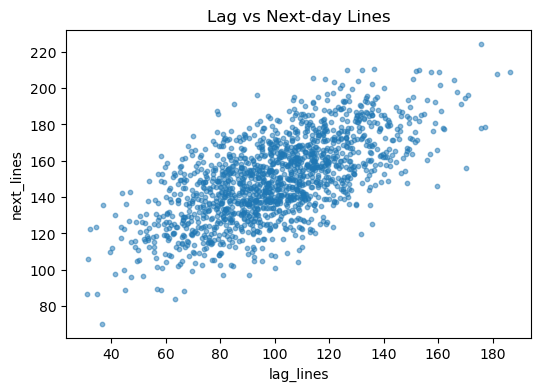

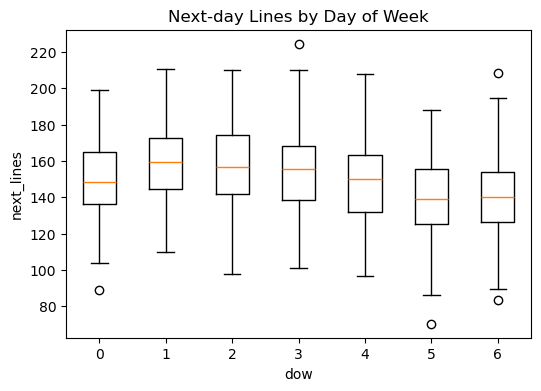

In [5]:
# %% [markdown]
# Quick EDA plots

# %%
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data["lag_lines"], data["next_lines"], s=10, alpha=0.5)
ax.set_title("Lag vs Next-day Lines")
ax.set_xlabel("lag_lines"); ax.set_ylabel("next_lines")
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot([data.loc[data.dow==d,"next_lines"] for d in range(7)], labels=list(range(7)))
ax.set_title("Next-day Lines by Day of Week")
ax.set_xlabel("dow"); ax.set_ylabel("next_lines")
plt.show()


In [7]:
# %% [markdown]
# Train/Validation/Test split

# %%
X = data[["dow","is_promo","price_index","lag_lines"]].astype(float).values
y = data["next_lines"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=7)
X_val,   X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=7)

X_train.shape, X_val.shape, X_test.shape


((1050, 4), (225, 4), (225, 4))

In [9]:
# %% [markdown]
# # 3) TensorFlow 101
# We'll create tensors, show shapes/dtypes, demonstrate broadcasting,
# and compute gradients with GradientTape.

# %%
# Tensors
a = tf.constant([[1., 2.],[3., 4.]], dtype=tf.float32)
b = tf.constant([10., 20.], dtype=tf.float32)

print("a:", a.shape, a.dtype)
print("b:", b.shape, b.dtype)

# Broadcasting: adds b to each row of a
c = a + b
print("c:", c.numpy())

# Variables (trainable)
w = tf.Variable(0.5)   # a single scalar weight

# Simple function: f(w) = (w - 2)^2; df/dw = 2*(w-2)
with tf.GradientTape() as tape:
    f = (w - 2.0)**2
grad = tape.gradient(f, w)
print("f(w)=", float(f.numpy()), " df/dw=", float(grad.numpy()))


a: (2, 2) <dtype: 'float32'>
b: (2,) <dtype: 'float32'>
c: [[11. 22.]
 [13. 24.]]
f(w)= 2.25  df/dw= -3.0


In [11]:
# %% [markdown]
# # 4) Keras model: compile, train, evaluate

# %%
tf.random.set_seed(7)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1)   # regression
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
             tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=32,
    callbacks=[es],
    verbose=0
)

print("Stopped after", len(history.history["loss"]), "epochs")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

Stopped after 200 epochs


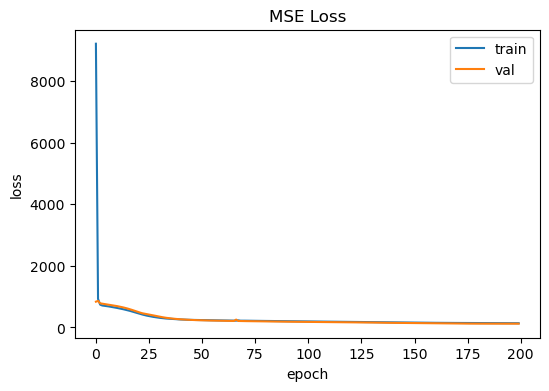

In [12]:
# %% [markdown]
# Plot training curves

# %%
hist = history.history
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(hist["loss"], label="train")
ax.plot(hist["val_loss"], label="val")
ax.set_title("MSE Loss")
ax.set_xlabel("epoch"); ax.set_ylabel("loss"); ax.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test MAE:  8.24
Test MAPE: 5.57%
R²:        0.788


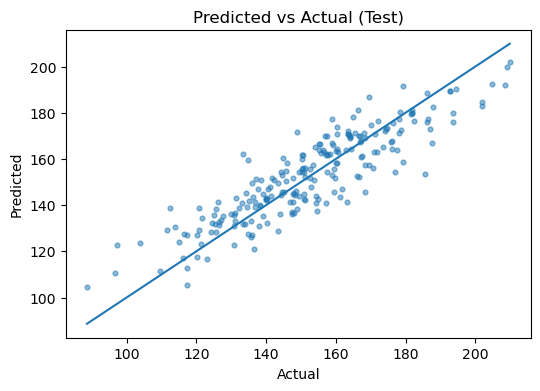

In [15]:
# %% [markdown]
# Evaluate on test set & visualize predictions

# %%
y_pred = model.predict(X_test).ravel()

mae = np.mean(np.abs(y_test - y_pred))
mape = np.mean(np.abs((y_test - y_pred)/np.clip(y_test, 1e-8, None))) * 100
r2 = r2_score(y_test, y_pred)

print(f"Test MAE:  {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R²:        {r2:.3f}")

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test, y_pred, s=12, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims)
ax.set_title("Predicted vs Actual (Test)")
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
plt.show()


In [17]:
# %% [markdown]
# # 5) Custom train step with GradientTape (+ tf.function)
# We'll run a few manual steps and compare to model.fit() behavior.

# %%
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function  # JIT-compile this step into a TF graph for speed
def train_step(xb, yb):
    with tf.GradientTape() as tape:
        preds = model(xb, training=True)
        loss = loss_fn(yb, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Run a tiny extra mini-epoch to see it working
batch_idx = np.random.choice(len(X_train), size=64, replace=False)
x_batch = tf.convert_to_tensor(X_train[batch_idx], dtype=tf.float32)
y_batch = tf.convert_to_tensor(y_train[batch_idx].reshape(-1,1), dtype=tf.float32)

loss_val = train_step(x_batch, y_batch)
print("One manual train_step() loss:", float(loss_val.numpy()))


One manual train_step() loss: 91.96192932128906


In [ ]:
# 02 — TensorFlow Step‑by‑Step: From Tensors to Training (Supply Chain Mini)

**Business toy problem:** predict next‑day order lines from day-of-week, promo flag, price index, and yesterday’s lines.

**You’ll learn:**
- Tensors, broadcasting, eager vs graph (`tf.function`)
- Autodiff with `GradientTape`
- Keras model build/compile/train (`model.fit`) + custom `train_step`
- Evaluation (MAE/MAPE/R²), plots, and SavedModel export

**Run locally**
```bash
python -m venv .venv && source .venv/bin/activate  # (Windows: .venv\Scripts\activate)
pip install -r requirements.txt
jupyter lab
# open notebooks/02_tf_step_by_step_supply_chain.ipynb
